# CelebA

In [1]:
from jax import random
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
from dpkernel import dpmmd, dphsic
import numpy as np
from matplotlib import pyplot as plt
import pickle
from pathlib import Path
Path("results").mkdir(exist_ok=True)
%load_ext autoreload
%autoreload 2

In [2]:
from dpkernel import dpmmd, dphsic
from dpkernelU import dpmmd_U, dphsic_U
from tot import tot_mmd, tot_hsic
from sarrm import sarrm_mmd, sarrm_hsic, compute_sarrm_optimal_k_p_alpha0
from me import me
from sampler_celeba import sampler_celeba_2ST, load_celeba_2ST

In [3]:
# define all tests to take as inputs: key, X, Y, epsilon

# dpmmd is already of the form dpmmd(key, X, Y, epsilon)
# dphsic is already of the form dphsic(key, X, Y, epsilon)

# since we use B = 2000
def dpmmd_naive(key, X, Y, epsilon): 
    return dpmmd(key, X, Y, epsilon / 2000 * 2)

def dpmmd_U_lower(key, X, Y, epsilon): 
    return dpmmd_U(key, X, Y, epsilon, bound_sensitivity='lower')

def sarrm__mmd(key, X, Y, epsilon): 
    return sarrm_mmd(key, X, Y, *sarrm_dictionary[round(float(epsilon), 5)])

# the tot parameters S and alpha0 have been chosen empirically to maximize power
def tot__mmd(key, X, Y, epsilon): 
    assert X.shape[0] == Y.shape[0]
    n = X.shape[0]
    alpha = 0.05
    return tot_mmd(
        key=key, 
        X=X, 
        Y=Y, 
        epsilon=epsilon, 
        S=round(float(jnp.sqrt(n))), 
        alpha0=5 * alpha,
    )


In [ ]:
# Either:
# [1] Create dictionary of parameters for the SARRM test
# Or:
# [2] Load the precomputed dictionary of parameters for the SARRM test

In [4]:
# [1] Create dictionary of parameters for the SARRM test
sarrm_dictionary = {}
alpha = 0.05
n = 500
epsilons = jnp.concatenate(
    (
        jnp.linspace(1 / n, 10 / jnp.sqrt(n), 6),
        jnp.linspace(10 / jnp.sqrt(n), 1, 6),
        jnp.linspace(1, 5 * jnp.sqrt(n), 6),
        jnp.linspace(1 / jnp.sqrt(n), jnp.sqrt(n), 6),
        jnp.array([jnp.sqrt(n) / 10, 1, 10 / jnp.sqrt(n)]),
        jnp.array([10 / jnp.sqrt(n) for n in (200, 400, 600, 800, 1000)]),
        jnp.array([jnp.sqrt(n) / 10 for n in (200, 400, 600, 800, 1000)]),
    )
)
for epsilon in epsilons:
    k, p, alpha0 = compute_sarrm_optimal_k_p_alpha0(alpha, epsilon, verbose=False)
    sarrm_dictionary[round(float(epsilon), 5)] = (k, p, alpha0)

In [7]:
# [2] Load the precomputed dictionary of parameters for the SARRM test
with open('results/sarrm_dictionary_celeba.pickle', 'rb') as handle:
    sarrm_dictionary = pickle.load(handle)

# Two-Sample Testing

In [7]:
celeba_2ST = load_celeba_2ST(3000)

## Vary privacy

### Power: Vary privacy (high privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 500
epsilons = jnp.linspace(1 / n, 10 / jnp.sqrt(n), 6)
corruption = 1
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
key = random.PRNGKey(42)
for s in range(len(epsilons)):
    epsilon = epsilons[s]
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
                outputs[t, s, i] = test(
                    subkey,
                    X,
                    Y,
                    epsilon,
                )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/celeba_mmd_power_vary_privacy_high.npy", power)
jnp.save("results/celeba_mmd_power_vary_privacy_high_x_axis.npy", epsilons)

dpmmd 
 [0.065 0.12  0.225 0.48  0.77  0.865] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06  0.055] 

dpmmd_U 
 [0.065 0.065 0.07  0.04  0.065 0.06 ] 

tot_mmd 
 [0.05  0.065 0.13  0.265 0.38  0.52 ] 

sarrm_mmd 
 [-1.     0.035  0.05   0.05   0.07   0.095] 



Text(0.5, 1.0, 'Two-sample testing\n High privacy 1/n to 10/sqrt(n)\n Sample size 500\n Corruption 1')

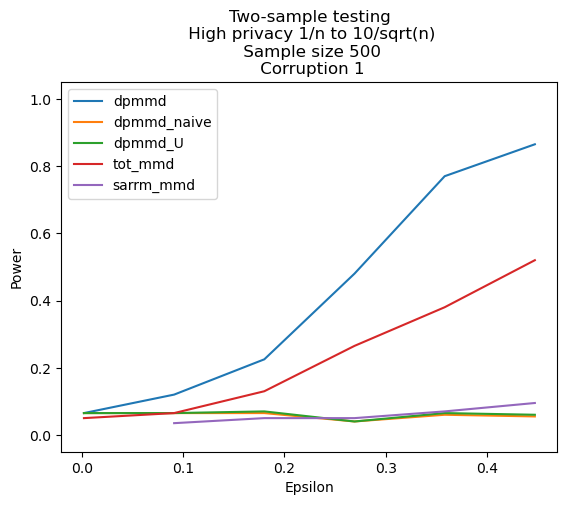

In [2]:
# load results
power = jnp.load("results/celeba_mmd_power_vary_privacy_high.npy")
x_axis = jnp.load("results/celeba_mmd_power_vary_privacy_high_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n High privacy 1/n to 10/sqrt(n)'
    '\n Sample size 500'
    '\n Corruption 1'
)

### Power: Vary privacy (mid privacy regime)

In [ ]:
# parameters
repetitions = 200 
m = n = 500
epsilons = jnp.linspace(10 / jnp.sqrt(n), 1, 6)
corruption = 0.6
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
key = random.PRNGKey(42)
for s in range(len(epsilons)):
    epsilon = epsilons[s]
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results      
power = jnp.mean(outputs, -1)
jnp.save("results/celeba_mmd_power_vary_privacy_mid.npy", power)
jnp.save("results/celeba_mmd_power_vary_privacy_mid_x_axis.npy", epsilons)

dpmmd 
 [0.265 0.47  0.535 0.71  0.71  0.805] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06  0.055] 

dpmmd_U 
 [0.065 0.08  0.07  0.04  0.065 0.06 ] 

tot_mmd 
 [0.13  0.115 0.16  0.21  0.205 0.205] 

sarrm_mmd 
 [0.08  0.06  0.07  0.115 0.06  0.105] 



Text(0.5, 1.0, 'Two-sample testing\n Mid privacy 10/sqrt(n) to 1\n Sample size 500\n Corruption 0.6')

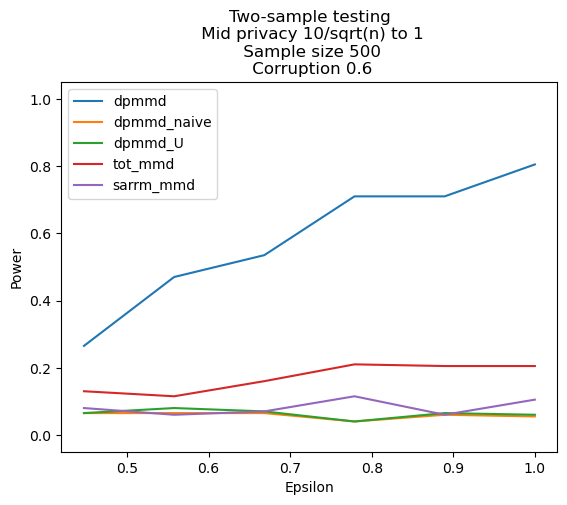

In [3]:
# load results
power = jnp.load("results/celeba_mmd_power_vary_privacy_mid.npy")
x_axis = jnp.load("results/celeba_mmd_power_vary_privacy_mid_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Mid privacy 10/sqrt(n) to 1'
    '\n Sample size 500'
    '\n Corruption 0.6'
)

### Power: Vary privacy (low privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 500
epsilons = jnp.linspace(1, 5 * jnp.sqrt(n), 6)
corruption = 0.5
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
key = random.PRNGKey(42)
for s in range(len(epsilons)):
    epsilon = epsilons[s]
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
                outputs[t, s, i] = test(
                    subkey,
                    X,
                    Y,
                    epsilon,
                )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/celeba_mmd_power_vary_privacy_low.npy", power)
jnp.save("results/celeba_mmd_power_vary_privacy_low_x_axis.npy", epsilons)

dpmmd 
 [0.49  0.925 0.925 0.93  0.91  0.92 ] 

dpmmd_naive 
 [0.065 0.08  0.07  0.045 0.065 0.065] 

dpmmd_U 
 [0.065 0.28  0.53  0.75  0.76  0.88 ] 

tot_mmd 
 [0.13  0.15  0.145 0.22  0.17  0.215] 

sarrm_mmd 
 [0.05  0.42  0.445 0.445 0.395 0.39 ] 



Text(0.5, 1.0, 'Two-sample testing\n Low privacy 1 to 5sqrt(n)\n Sample size 500\n Corruption 0.5')

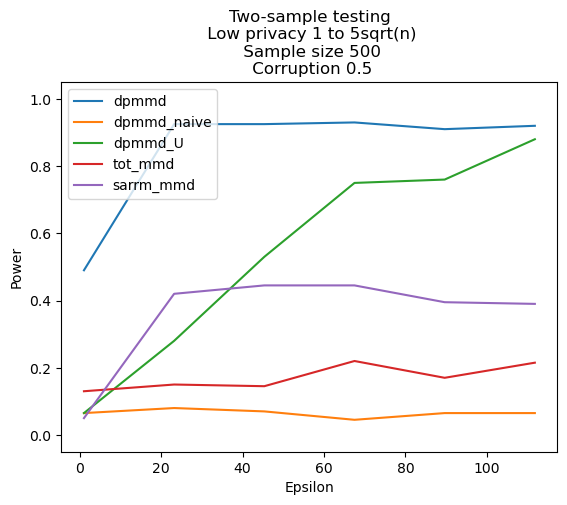

In [5]:
# load results
power = jnp.load("results/celeba_mmd_power_vary_privacy_low.npy")
x_axis = jnp.load("results/celeba_mmd_power_vary_privacy_low_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Low privacy 1 to 5sqrt(n)'
    '\n Sample size 500'
    '\n Corruption 0.5'
)

### Level: Vary privacy

In [ ]:
# parameters
repetitions = 200
m = n = 500
epsilons = jnp.linspace(1 / jnp.sqrt(n), jnp.sqrt(n), 6) 
corruption = 0
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
key = random.PRNGKey(42)
for s in range(len(epsilons)):
    epsilon = epsilons[s]
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/celeba_mmd_level_vary_privacy.npy", power)
jnp.save("results/celeba_mmd_level_vary_privacy_x_axis.npy", epsilons)

dpmmd 
 [0.065 0.02  0.01  0.02  0.03  0.07 ] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06  0.055] 

dpmmd_U 
 [0.065 0.065 0.065 0.045 0.05  0.055] 

tot_mmd 
 [0.06  0.07  0.025 0.06  0.05  0.035] 

sarrm_mmd 
 [0.04  0.02  0.055 0.04  0.025 0.015] 



Text(0.5, 1.0, 'Two-sample testing\n Privacy 1/sqrt(n) to sqrt(n)\n Sample size 500')

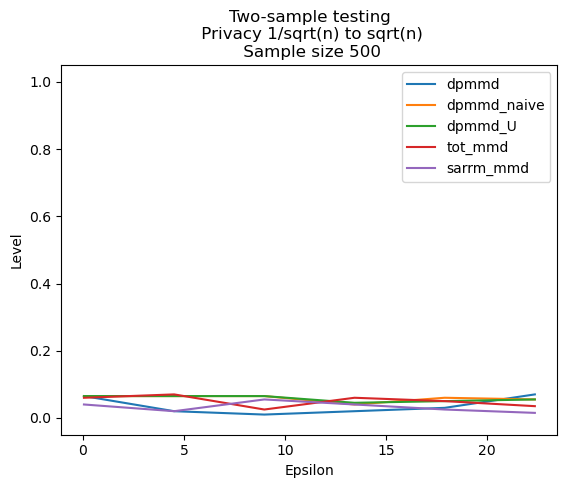

In [6]:
# load results
power = jnp.load("results/celeba_mmd_level_vary_privacy.npy")
x_axis = jnp.load("results/celeba_mmd_level_vary_privacy_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Level')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Privacy 1/sqrt(n) to sqrt(n)'
    '\n Sample size 500'
)

## Vary sample size

### Power: Vary sample size (high privacy regime)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (200, 400, 600, 800, 1000)
corruption = 0.7
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
key = random.PRNGKey(42)
for s in range(len(sample_sizes)):
    n = m = sample_sizes[s]
    epsilon = 10 / jnp.sqrt(n)
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/celeba_mmd_power_vary_n_high.npy", power)
jnp.save("results/celeba_mmd_power_vary_n_high_x_axis.npy", sample_sizes)

dpmmd 
 [0.125 0.34  0.57  0.77  0.86 ] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06 ] 

dpmmd_U 
 [0.065 0.08  0.07  0.04  0.065] 

tot_mmd 
 [0.115 0.19  0.19  0.285 0.35 ] 

sarrm_mmd 
 [0.07  0.04  0.035 0.065 0.065] 



Text(0.5, 1.0, 'Two-sample testing\n High privacy 10/sqrt(n)\n Corruption 0.7')

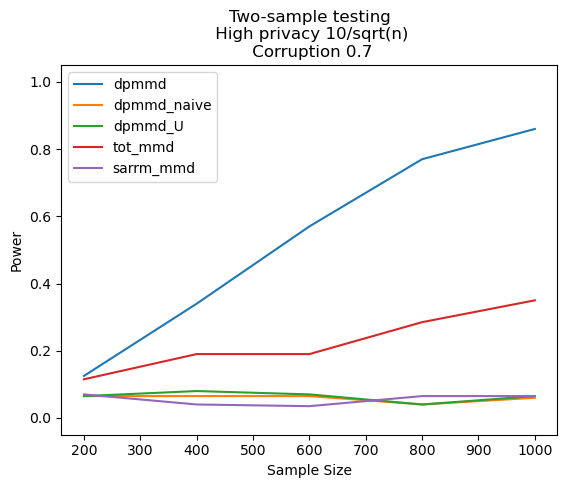

In [12]:
# load results
power = jnp.load("results/celeba_mmd_power_vary_n_high.npy")
x_axis = jnp.load("results/celeba_mmd_power_vary_n_high_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n High privacy 10/sqrt(n)'
    '\n Corruption 0.7'
)

### Power: Vary sample size (mid privacy regime)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (200, 400, 600, 800, 1000)
corruption = 0.5
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
key = random.PRNGKey(42)
for s in range(len(sample_sizes)):
    n = m = sample_sizes[s]
    epsilon = 1
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(jnp.array(outputs), -1)
jnp.save("results/celeba_mmd_power_vary_n_mid.npy", power)
jnp.save("results/celeba_mmd_power_vary_n_mid_x_axis.npy", sample_sizes)

dpmmd 
 [0.1   0.375 0.69  0.93  0.97 ] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06 ] 

dpmmd_U 
 [0.065 0.08  0.07  0.04  0.065] 

tot_mmd 
 [0.07  0.095 0.11  0.22  0.295] 

sarrm_mmd 
 [0.04  0.1   0.11  0.135 0.165] 



Text(0.5, 1.0, 'Two-sample testing\n Mid privacy 1\n Corruption 0.5')

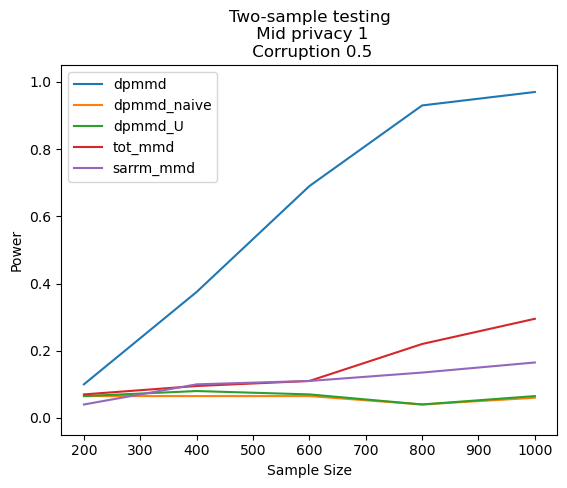

In [11]:
# load results
power = jnp.load("results/celeba_mmd_power_vary_n_mid.npy")
x_axis = jnp.load("results/celeba_mmd_power_vary_n_mid_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Mid privacy 1'
    '\n Corruption 0.5'
)

### Power: Vary sample size (low privacy regime)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (200, 400, 600, 800, 1000)
corruption = 0.4
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
key = random.PRNGKey(42)
for s in range(len(sample_sizes)):
    n = m = sample_sizes[s]
    epsilon = jnp.sqrt(n) / 10
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/celeba_mmd_power_vary_n_low.npy", power)
jnp.save("results/celeba_mmd_power_vary_n_low_x_axis.npy", sample_sizes)

dpmmd 
 [0.11  0.34  0.605 0.885 0.99 ] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06 ] 

dpmmd_U 
 [0.065 0.07  0.07  0.045 0.065] 

tot_mmd 
 [0.1   0.075 0.145 0.205 0.18 ] 

sarrm_mmd 
 [0.045 0.125 0.135 0.36  0.49 ] 



Text(0.5, 1.0, 'Two-sample testing\n Low privacy 10/sqrt(n)\n Corruption 0.4')

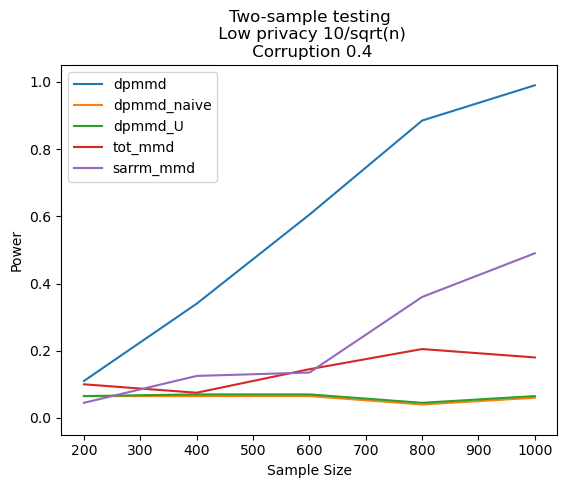

In [10]:
# load results
power = jnp.load("results/celeba_mmd_power_vary_n_low.npy")
x_axis = jnp.load("results/celeba_mmd_power_vary_n_low_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Low privacy 10/sqrt(n)'
    '\n Corruption 0.4'
)

### Level: Vary sample size (high privacy regime)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (200, 400, 600, 800, 1000)
corruption = 0
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
key = random.PRNGKey(42)
for s in range(len(sample_sizes)):
    n = m = sample_sizes[s]
    epsilon = 10 / jnp.sqrt(n)
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(jnp.array(outputs), -1)
jnp.save("results/celeba_mmd_level_vary_n.npy", power)
jnp.save("results/celeba_mmd_level_vary_n_x_axis.npy", sample_sizes)

dpmmd 
 [0.055 0.06  0.055 0.035 0.04 ] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06 ] 

dpmmd_U 
 [0.065 0.065 0.065 0.04  0.06 ] 

tot_mmd 
 [0.06  0.035 0.035 0.065 0.065] 

sarrm_mmd 
 [0.1   0.06  0.035 0.04  0.02 ] 



Text(0.5, 1.0, 'Two-sample testing\n High privacy sqrt(n)/10')

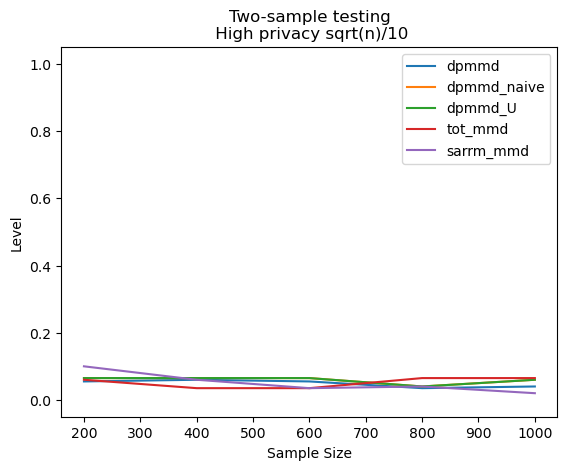

In [13]:
# load results
power = jnp.load("results/celeba_mmd_level_vary_n.npy")
x_axis = jnp.load("results/celeba_mmd_level_vary_n_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Level')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n High privacy sqrt(n)/10'
)

## Vary corruption

### Power: Vary corruption (high privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 500
epsilon = 10 / jnp.sqrt(n)
corruptions = (0.2, 0.4, 0.6, 0.8, 1)
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
key = random.PRNGKey(42)
for s in range(len(corruptions)):
    corruption = corruptions[s]
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(jnp.array(outputs), -1)
jnp.save("results/celeba_mmd_power_vary_c_high.npy", power)
jnp.save("results/celeba_mmd_power_vary_c_high_x_axis.npy", corruptions)

dpmmd 
 [0.06  0.15  0.285 0.655 0.88 ] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06 ] 

dpmmd_U 
 [0.065 0.065 0.07  0.04  0.065] 

tot_mmd 
 [0.055 0.07  0.11  0.29  0.475] 

sarrm_mmd 
 [0.075 0.03  0.06  0.07  0.09 ] 



Text(0.5, 1.0, 'Two-sample testing\n Sample size 500\n High privacy 10/sqrt(n)')

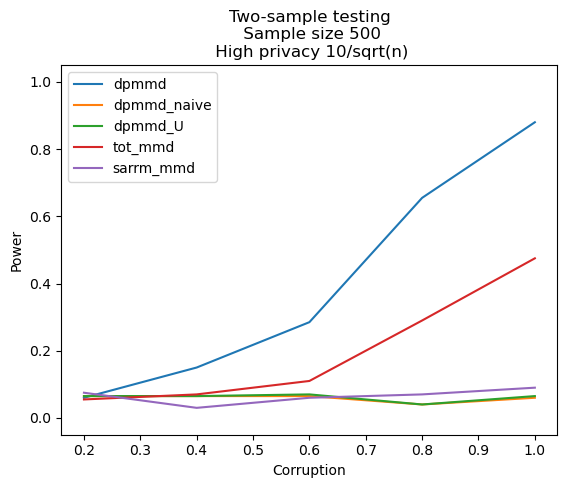

In [14]:
# load results
power = jnp.load("results/celeba_mmd_power_vary_c_high.npy")
x_axis = jnp.load("results/celeba_mmd_power_vary_c_high_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Corruption')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Sample size 500'
    '\n High privacy 10/sqrt(n)'
)

### Power: Vary corruption (mid privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 500
epsilon = 1
corruptions = (0.2, 0.4, 0.6, 0.8, 1)
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
key = random.PRNGKey(42)
for s in range(len(corruptions)):
    corruption = corruptions[s]
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/celeba_mmd_power_vary_c_mid.npy", power)
jnp.save("results/celeba_mmd_power_vary_c_mid_x_axis.npy", corruptions)

dpmmd 
 [0.07  0.29  0.78  0.965 0.99 ] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06 ] 

dpmmd_U 
 [0.065 0.07  0.07  0.045 0.065] 

tot_mmd 
 [0.05  0.09  0.21  0.52  0.775] 

sarrm_mmd 
 [0.035 0.09  0.11  0.305 0.61 ] 



Text(0.5, 1.0, 'Two-sample testing\n Sample size 500\n Mid privacy 1')

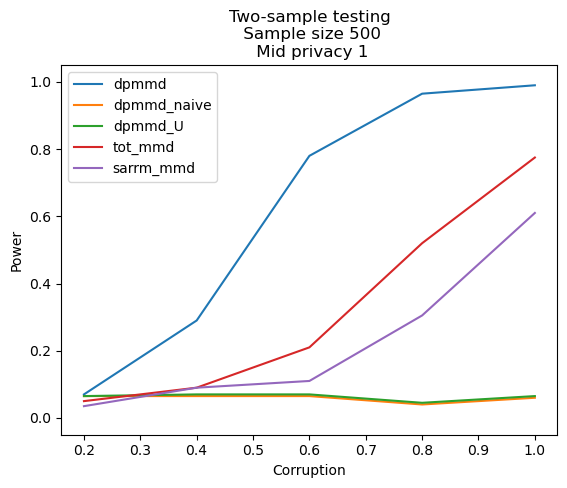

In [15]:
# load results
power = jnp.load("results/celeba_mmd_power_vary_c_mid.npy")
x_axis = jnp.load("results/celeba_mmd_power_vary_c_mid_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Corruption')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Sample size 500'
    '\n Mid privacy 1'
)

### Power: Vary corruption (low privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 500
epsilon = jnp.sqrt(n) / 10
corruptions = (0.2, 0.4, 0.6, 0.8, 1)
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# run experiment
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
key = random.PRNGKey(42)
for s in range(len(corruptions)):
    corruption = corruptions[s]
    for i in range(repetitions):
        key, subkey = random.split(key)
        X, Y = sampler_celeba_2ST(subkey, m, n, corruption, celeba_2ST)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/celeba_mmd_power_vary_c_low.npy", power)
jnp.save("results/celeba_mmd_power_vary_c_low_x_axis.npy", corruptions)

dpmmd 
 [0.09  0.545 0.995 1.    1.   ] 

dpmmd_naive 
 [0.065 0.065 0.065 0.04  0.06 ] 

dpmmd_U 
 [0.065 0.08  0.08  0.045 0.095] 

tot_mmd 
 [0.045 0.105 0.265 0.565 0.865] 

sarrm_mmd 
 [0.055 0.195 0.485 0.94  1.   ] 



Text(0.5, 1.0, 'Two-sample testing\n Sample size 500\n Low privacy sqrt(n)/10')

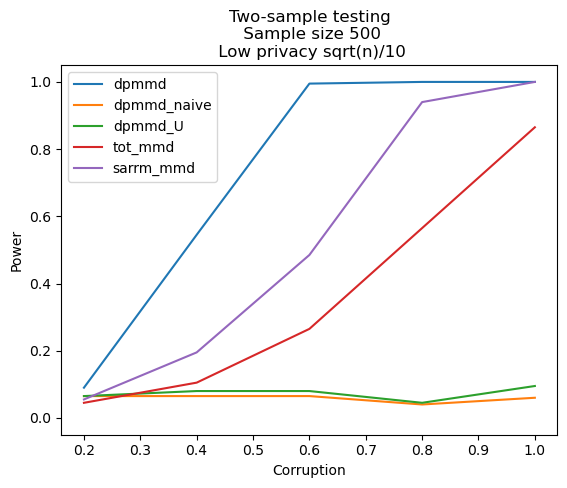

In [16]:
# load results
power = jnp.load("results/celeba_mmd_power_vary_c_low.npy")
x_axis = jnp.load("results/celeba_mmd_power_vary_c_low_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Corruption')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Sample size 500'
    '\n Low privacy sqrt(n)/10'
)